In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
#모델링
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
plt.rcParams['font.family'] = 'Malgun Gothic'


In [3]:
#수원시 2025년 1월 ~ 3월 데이터 합치기
df1 = pd.read_csv('C:/Users/user-pc/Downloads/카드소비 데이터_202501/tbsh_gyeonggi_day_수원시.csv')
df2 = pd.read_csv('C:/Users/user-pc/Downloads/카드소비 데이터_202502/tbsh_gyeonggi_day_수원시.csv')
df3 = pd.read_csv('C:/Users/user-pc/Downloads/카드소비 데이터_202503/tbsh_gyeonggi_day_202503_수원시.csv')

In [4]:
df = pd.concat([df1,df2,df3], ignore_index=True)

In [5]:
df.to_csv('C:/Users/user-pc/Desktop/교안/df.csv',index=False)

In [6]:
#요약정보 출력
print(df.head())
print(df.info())
print(df.describe())

     ta_ymd  cty_rgn_no  admi_cty_no card_tpbuz_cd card_tpbuz_nm_1  \
0  20250101       41111     41111560           D02           소매/유통   
1  20250101       41111     41111560           D02           소매/유통   
2  20250101       41111     41111560           D02           소매/유통   
3  20250101       41111     41111560           D02           소매/유통   
4  20250101       41111     41111560           D02           소매/유통   

  card_tpbuz_nm_2  hour sex  age  day     amt  cnt  
0         건강/기호식품     3   M    4    3  144301    2  
1         건강/기호식품     4   M    5    3   31406    2  
2         건강/기호식품     4   M    8    3   73529    2  
3         건강/기호식품     5   M    7    3  458246    6  
4         건강/기호식품     6   F    5    3   73529    2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6934783 entries, 0 to 6934782
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ta_ymd           int64 
 1   cty_rgn_no       int64 
 2   admi_cty_no      int64 
 3 

In [7]:
df = df[['ta_ymd','card_tpbuz_nm_2','sex','age','hour','amt','cnt','day']]

In [8]:
#결측치 확인
print(df.isna().sum())
#결측치 없음

ta_ymd             0
card_tpbuz_nm_2    0
sex                0
age                0
hour               0
amt                0
cnt                0
day                0
dtype: int64


In [9]:
top_10 = df['card_tpbuz_nm_2'].value_counts().head(10).index

In [10]:
df=df[df['card_tpbuz_nm_2'].isin(top_10)] 

In [11]:
#데이터 column 분류하기
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

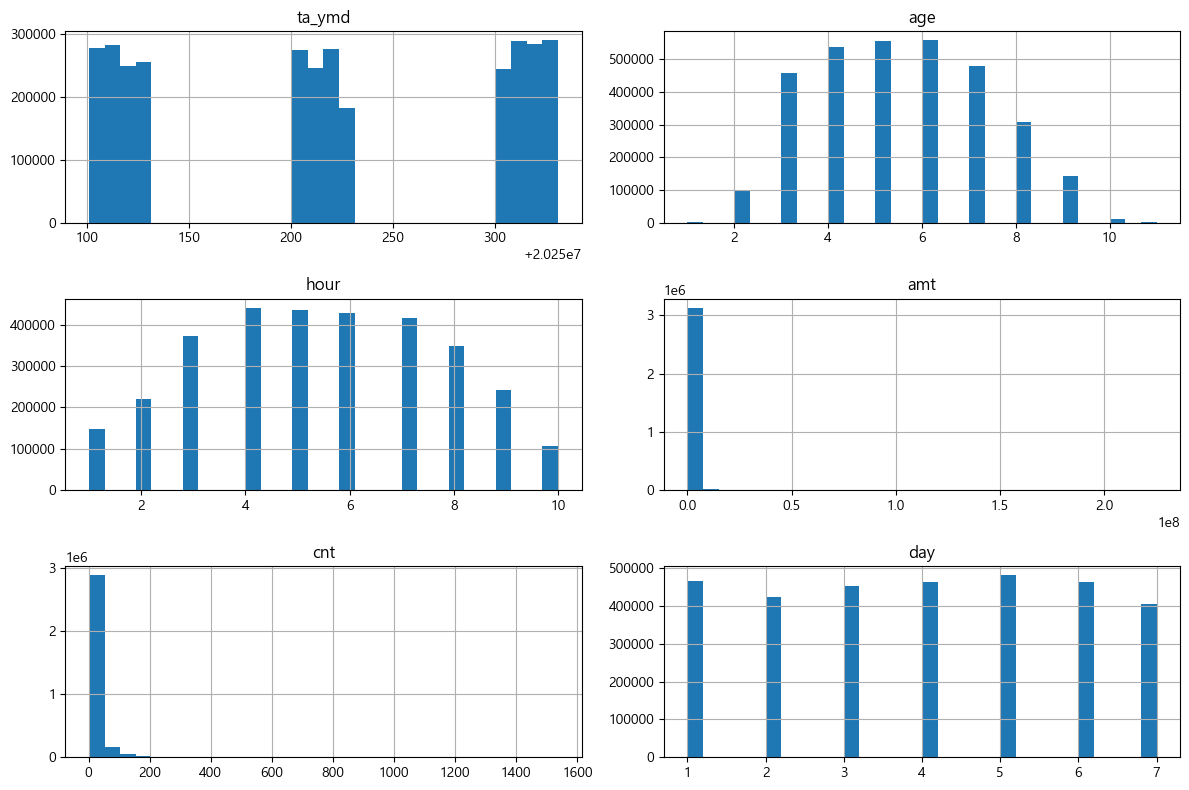

In [12]:
#수치형 변수 히스토그램
df[num_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

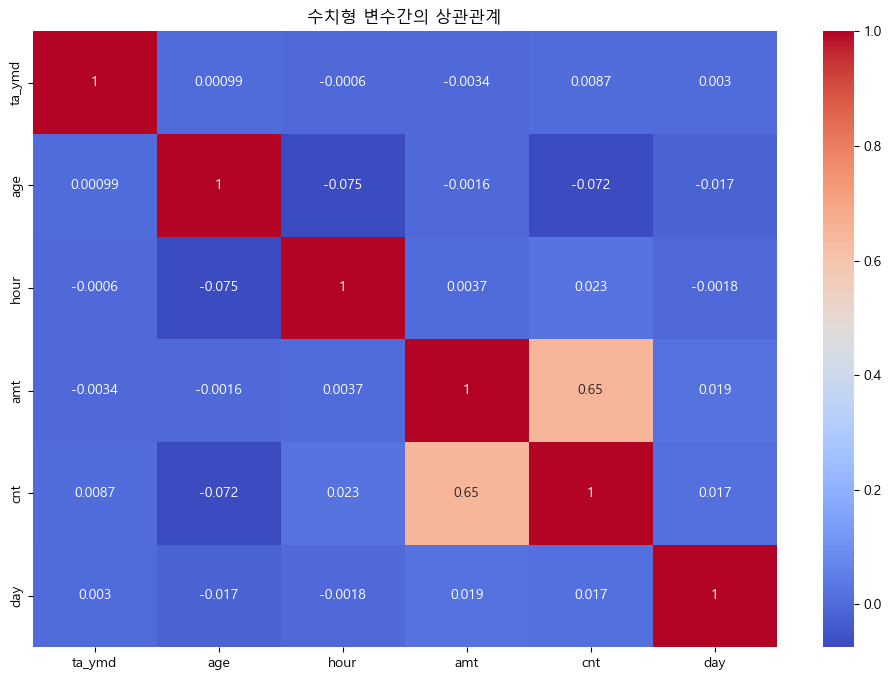

In [13]:
#수치형 변수 상관관계 히트맵
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('수치형 변수간의 상관관계')
plt.show()

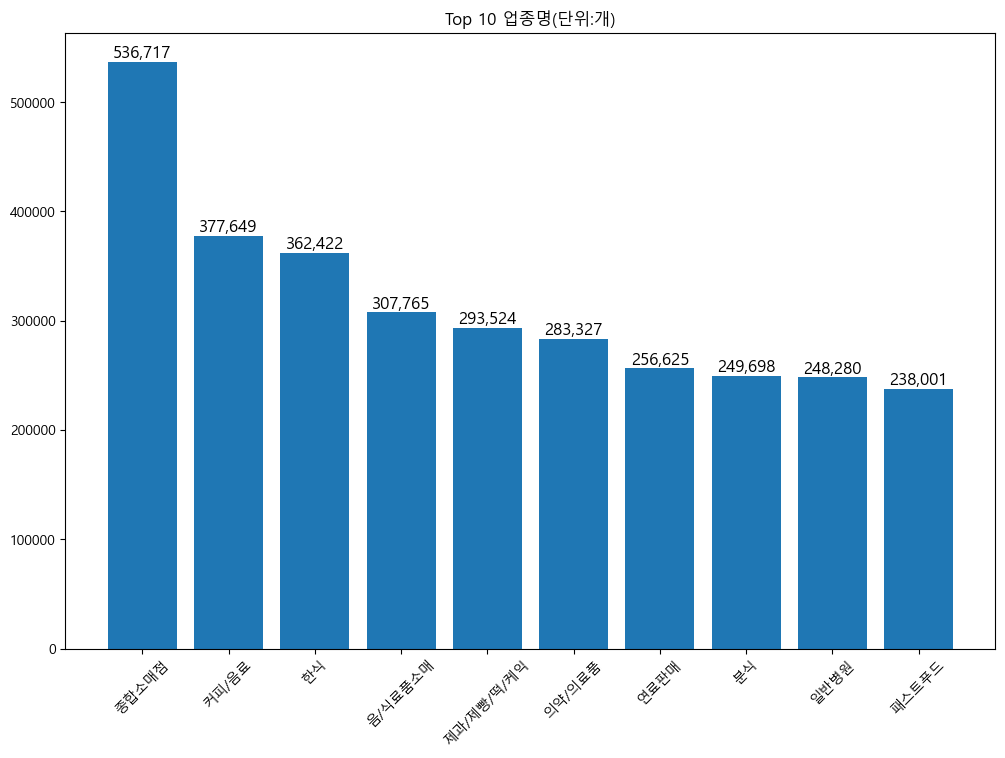

In [14]:
#범주형 변수 분포
plt.figure(figsize=(12,8))
top_categories = df['card_tpbuz_nm_2'].value_counts().head(10)
bars = plt.bar(top_categories.index, top_categories.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=12
    )
plt.title('Top 10 업종명(단위:개)')
plt.xticks(rotation=45)
plt.show()

In [15]:
df.to_csv('C:/Users/user-pc/Desktop/교안/df2.csv',index=False)

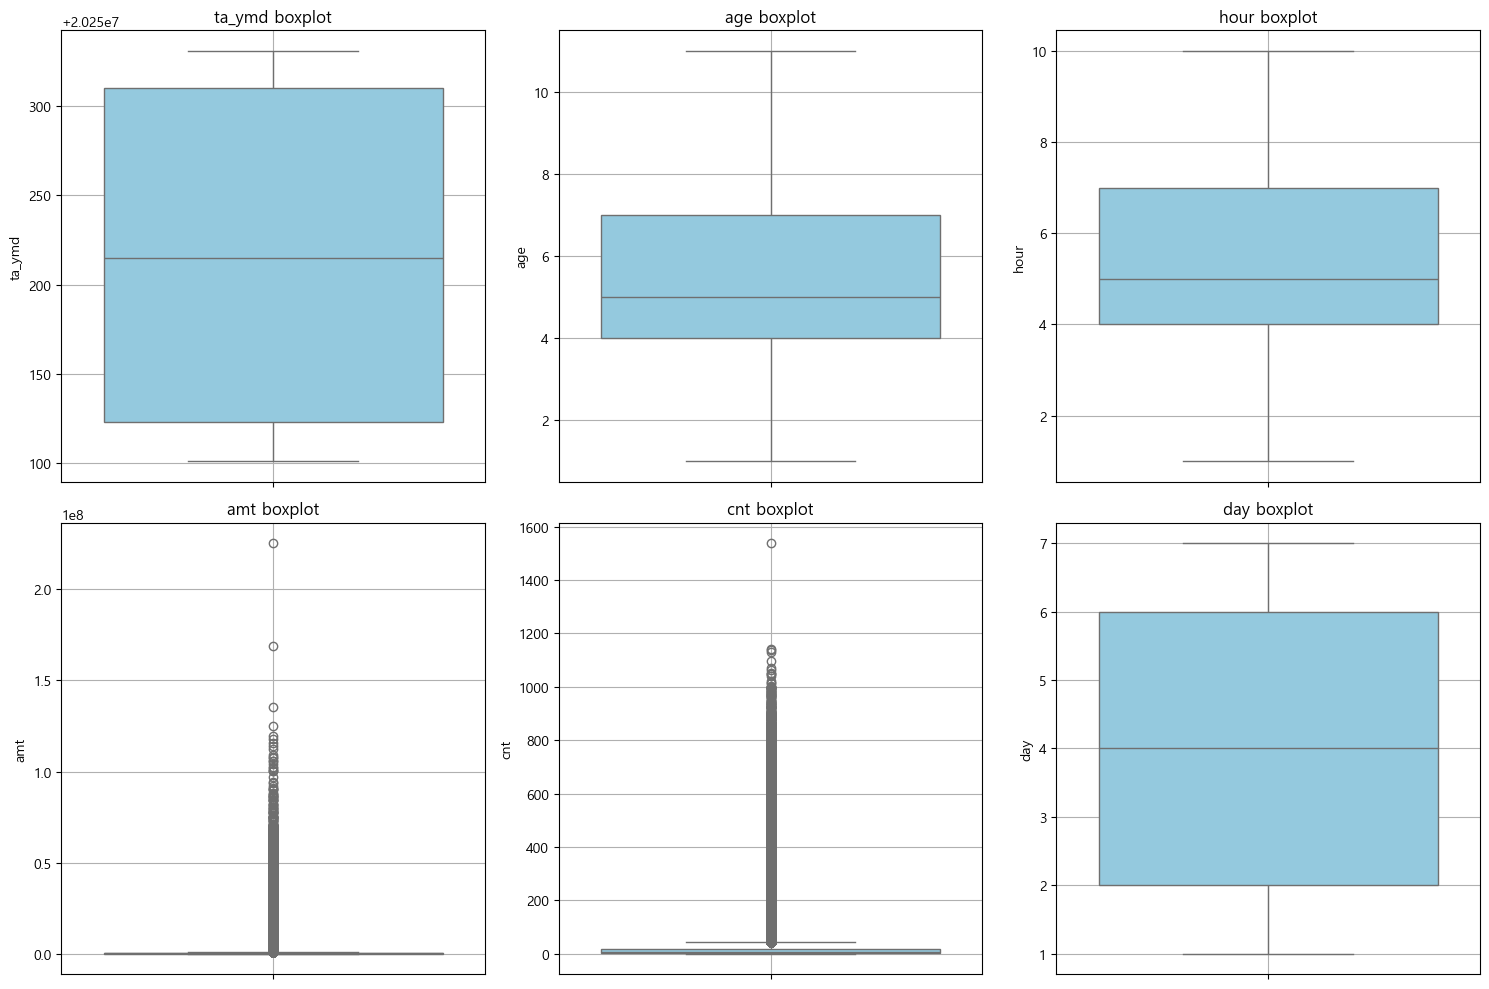

In [16]:
#박스플롯으로 분포와 이상치 확인하기
plt.figure(figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'{col} boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
#amt, cnt가 이상치가 많아 로그 변환 후 재시도
df['amt'] = np.log10(df['amt'])
df['cnt'] = np.log10(df['cnt'])

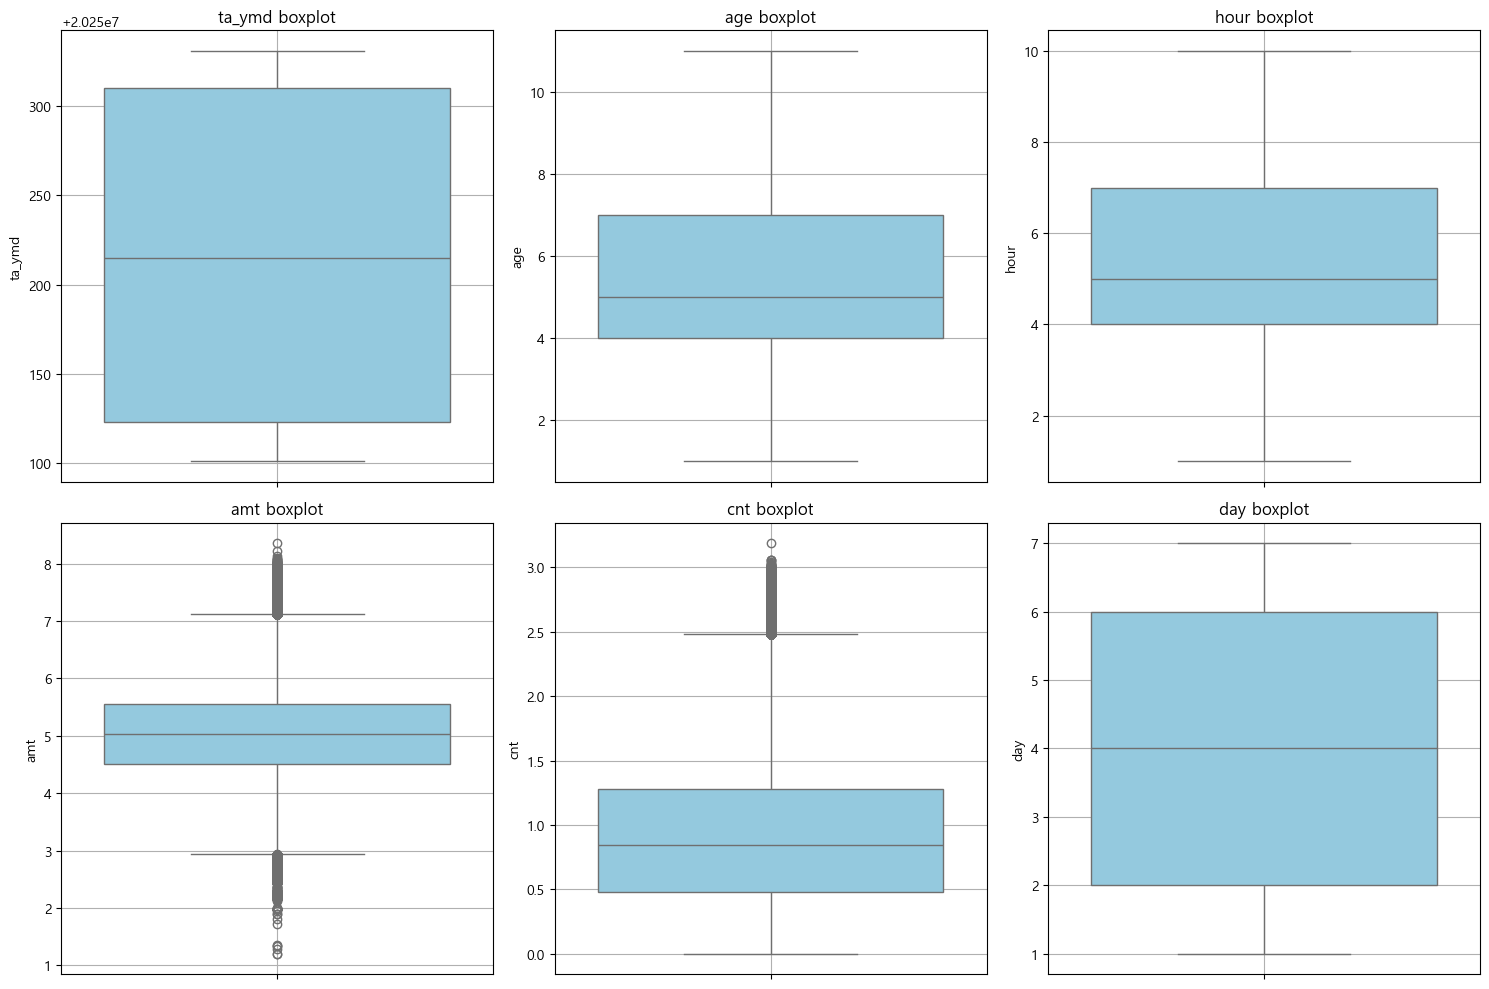

In [18]:
#박스플롯으로 분포와 이상치 다시 확인하기
plt.figure(figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'{col} boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()
#1. 중앙값 위치 : ta_ymd, amt, cnt, day는 중앙선이 가운데쯤 있으므로 대칭분포 / age, hour는 비대칭 분포
#2. 박스 너비(IQR) : 박스가 넓으면 데이터 분포가 퍼져 있는 것이고, 좁으면 분포가 조밀한 것
#3. 수염 길이 : age 처럼 긴 수염을 가지고 있으면 극단적인 값이 존재하는 것이고 cnt처럼 수염이 비대칭이면 분포가 한쪽으로 치우쳐 있다는 것
#4. 이상치 : 로그변환을 하였음에도 불구하고 amt와 cnt는 여전히 이상치(점의 형태)가 남아있는 모습이다.

In [89]:
# 1. 업종 또는 성별에 따라 매출금액과 구매횟수에 영향을 미칠까?
# H_0(귀무가설) : 업종 또는 성별에 따라 매출금액과 구매횟수에 영향을 미치지 않는다.
# H_1(대립가설): 업종 또는 성별에 따라 매출금액과 구매횟수에 영향을 미친다.

In [20]:
#모두 p-value 값이 0.05보다 작으므로 각 범주에 따라 수치형 값의 평균 차이가 통계적으로 유의함을 알 수 있다.
#다만 p-value값이 모두 0.05보다 작으므로 F값은 값이 클수록 집단 간 유의미한 관계가 있다고 볼 수 있으므로 F값이 크면서 p-value값이 작은 값들을 찾아보면
#card_tpbuz_nm_2 : cnt > amt > age > hour > day > ta_ymd / sex : cnt > amt > day > age > ta_ymd > hour 순으로 변수와 유의미한 관계가 있다.
#통계적으로 두 범주형 변수는 cnt의 영향을 제일 많이 받음을 알 수 있다.
for cat in cat_cols:
    for num in num_cols:
        groups = [df[df[cat]==level][num]for level in df[cat].unique()]

        if len(groups)>1:
            stat, p = f_oneway(*groups)
            print(f"{num} vs {cat} > F-{stat:.2f}, p-value={p:.4f}")
            if p < 0.05:
                print(f"유의수준 0.05보다 작으므로 귀무가설 기각.")
            else:
                print(f"유의수준 0.05보다 크므로 귀무가설 채택")
        else:
            print("그룹 수 부족")

ta_ymd vs card_tpbuz_nm_2 > F-15.88, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
age vs card_tpbuz_nm_2 > F-5237.58, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
hour vs card_tpbuz_nm_2 > F-2212.19, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
amt vs card_tpbuz_nm_2 > F-64098.37, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
cnt vs card_tpbuz_nm_2 > F-67066.19, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
day vs card_tpbuz_nm_2 > F-1310.55, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
ta_ymd vs sex > F-6.54, p-value=0.0106
유의수준 0.05보다 작으므로 귀무가설 기각.
age vs sex > F-67.00, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
hour vs sex > F-5.44, p-value=0.0197
유의수준 0.05보다 작으므로 귀무가설 기각.
amt vs sex > F-2856.07, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
cnt vs sex > F-6889.39, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.
day vs sex > F-113.89, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.


In [21]:
#모델링 시작
df['sex'] = LabelEncoder().fit_transform(df['sex'])
df['card_tpbuz_nm_2'] = LabelEncoder().fit_transform(df['card_tpbuz_nm_2'])

In [71]:
X = df[['sex', 'age', 'card_tpbuz_nm_2', 'ta_ymd', 'hour', 'day']]
y_amt = df['amt']
y_cnt = df['cnt']

In [72]:
X_train, X_test, y_amt_train, y_amt_test = train_test_split(X,y_amt,test_size=0.2, random_state=42)
model_amt = LGBMRegressor().fit(X_train, y_amt_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 2523206, number of used features: 6
[LightGBM] [Info] Start training from score 5.037879


In [73]:
# RMSE(amt) : 약 0.5542 > 로그 역변환 시 log_10 0.5542 = 약 3.59배 오차, R^2 = 약 0.4514 
# 이 값들로 하여금 이 amt는 45.14% 설명력을 보이는 모델이다. > 모델성능향상이 어느정도 필요하다.
y_pred_amt = model_amt.predict(X_test)
print("RMSE (amt):",np.sqrt(mean_squared_error(y_amt_test,y_pred_amt)))
print("R^2 (amt):",r2_score(y_amt_test,y_pred_amt))

RMSE (amt): 0.5544819885296772
R^2 (amt): 0.4508184708904457


In [74]:
X_train, X_test, y_cnt_train, y_cnt_test = train_test_split(X,y_cnt,test_size=0.2,random_state=42)
model_cnt = LGBMRegressor().fit(X_train, y_cnt_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 2523206, number of used features: 6
[LightGBM] [Info] Start training from score 0.909008


In [75]:
# RMSE(cnt) : 약 0.3707 > 로그 역변환 시 log_10 0.3707 = 약 2.34배 오차, R^2 = 약 0.5114 
# 이 값들로 하여금 이 cnt는 amt에 비해 상대적으로 더 정확한 예측을 하며 설명력은 51.14%로 보통 수준이며 어느정도 의미 있는 수준인 모델이다.
y_pred_cnt = model_cnt.predict(X_test)
print("RMSE (cnt):",np.sqrt(mean_squared_error(y_cnt_test,y_pred_cnt)))
print("R^2 (cnt):",r2_score(y_cnt_test,y_pred_cnt))

RMSE (cnt): 0.37063447100638414
R^2 (cnt): 0.5116623131658234


In [76]:
#2. 연령대에 따라 각 매장을 많이 방문하는 지 눈에 띄게 나타날까?
# H_0(귀무가설) : 연령대에 따라 각 매장을 많이 방문하는 경향은 없다.
# H_1(대립가설) : 연령대에 따라 각 매장을 많이 방문하는 경향이 있다.

In [86]:
groups = [df[df['card_tpbuz_nm_2']==level]['age']for level in df['card_tpbuz_nm_2'].unique()]
if len(groups)>1:
    stat, p = f_oneway(*groups)
    print(f"{'age'} vs {'card_tpbuz_nm_2'} > F-{stat:.2f}, p-value={p:.4f}")
    if p < 0.05:
        print(f"유의수준 0.05보다 작으므로 귀무가설 기각.")
    else:
        print(f"유의수준 0.05보다 크므로 귀무가설 채택")
else:
    print("그룹 수 부족")

age vs card_tpbuz_nm_2 > F-5237.58, p-value=0.0000
유의수준 0.05보다 작으므로 귀무가설 기각.


In [ ]:
y = df['age']
X = df[['sex', 'card_tpbuz_nm_2', 'ta_ymd', 'hour', 'day']]

In [81]:
X_train, X_test, y_card_train, y_card_test = train_test_split(X,y,test_size=0.2, random_state=42)
model_age = LGBMRegressor().fit(X_train, y_card_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 2523206, number of used features: 5
[LightGBM] [Info] Start training from score 5.419938


In [ ]:
#RMSE(age) : RMSE 값이 굉장히 낮으나 R^2 값은 거의 0에 가까우므로 이 모델은 설명력이 0.03% 수준임을 알 수 있다.
#즉, 연령대에 따라 각 매장을 많이 방문하는 빈도는 아무런 관련이 없다고 볼 수 있다.
y_pred_age = model_age.predict(X_test)
print("RMSE (age):",np.sqrt(mean_squared_error(y_card_test,y_pred_age)))
print("R^2 (age):",r2_score(y_card_test,y_pred_age))

RMSE (age): 1.7954079973133465
R^2 (age): 0.035476038310482294


In [58]:
# #향후(4월 이후) 고객 방문 시 매장별 amt, cnt 예측
# # 예시 입력 데이터 (4월 1일 15시, 30세 남성, 업종코드 5번 가정)
# new_data = pd.DataFrame({
#     'sex': [1],            # 예: 남성
#     'age': [30],           # 나이
#     'card_tpbuz_nm_2': [5],# 라벨 인코딩된 업종명
#     'ta_ymd': [20240401],  # 날짜
#     'hour': [15],          # 시간
#     'day': [1]             # 요일 (월요일 등)
# })

# # amt와 cnt 예측
# log_amt_pred = model_amt.predict(new_data)[0]
# log_cnt_pred = model_cnt.predict(new_data)[0]

# # 역로그 변환
# amt_pred = 10 ** log_amt_pred
# cnt_pred = 10 ** log_cnt_pred

# print("예상 매출금액 (amt):", round(amt_pred))
# print("예상 구매횟수 (cnt):", round(cnt_pred))


In [57]:
cat_features = ['sex', 'card_tpbuz_nm_2', 'hour_bin']  # 범주형 변수 리스트 (정확히 맞춰주세요)

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_amt_train, cat_features=cat_features, eval_set=(X_test, y_amt_test), early_stopping_rounds=50)
y_pred_cat = model.predict(X_test)

from sklearn.metrics import mean_squared_error
print("CatBoost RMSE:", mean_squared_error(y_amt_test, y_pred_cat, squared=False))

0:	learn: 0.7375975	test: 0.7360568	best: 0.7360568 (0)	total: 543ms	remaining: 4m 30s
100:	learn: 0.5715774	test: 0.5704651	best: 0.5704651 (100)	total: 28.6s	remaining: 1m 53s
200:	learn: 0.5618803	test: 0.5612009	best: 0.5612009 (200)	total: 58.1s	remaining: 1m 26s
300:	learn: 0.5580400	test: 0.5575045	best: 0.5575045 (300)	total: 1m 29s	remaining: 59.4s
400:	learn: 0.5560285	test: 0.5556607	best: 0.5556607 (400)	total: 1m 59s	remaining: 29.4s
499:	learn: 0.5547897	test: 0.5545182	best: 0.5545182 (499)	total: 2m 28s	remaining: 0us

bestTest = 0.5545182071
bestIteration = 499

CatBoost RMSE: 0.5545182079069176


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


amt 왜도: 0.07
cnt 왜도: 0.55


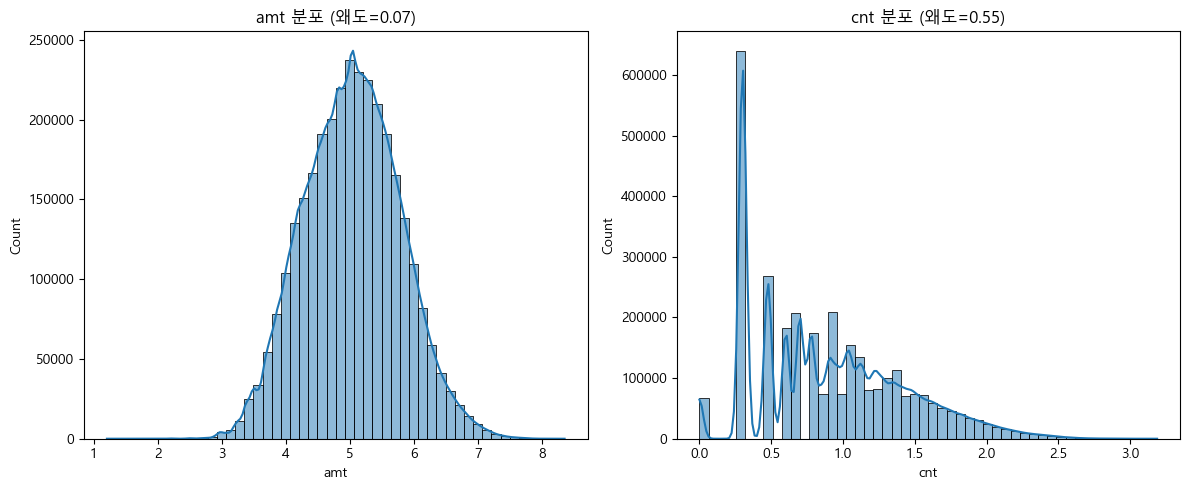

In [90]:
from scipy.stats import skew

# 왜도 계산
amt_skew = skew(df['amt'])
cnt_skew = skew(df['cnt'])

print(f"amt 왜도: {amt_skew:.2f}")
print(f"cnt 왜도: {cnt_skew:.2f}")

# 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['amt'], bins=50, kde=True)
plt.title(f"amt 분포 (왜도={amt_skew:.2f})")

plt.subplot(1, 2, 2)
sns.histplot(df['cnt'], bins=50, kde=True)
plt.title(f"cnt 분포 (왜도={cnt_skew:.2f})")

plt.tight_layout()
plt.show()

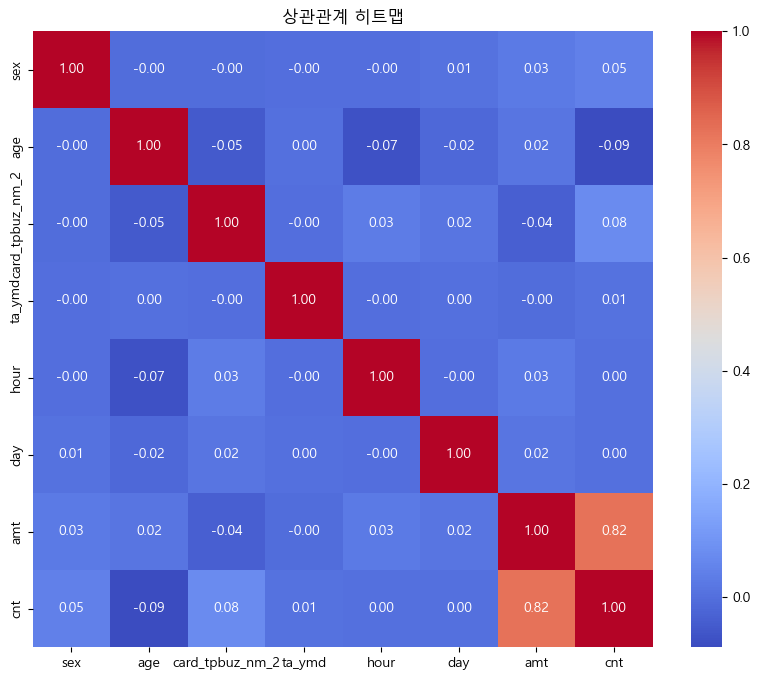

In [91]:
# 상관관계 분석 (수치형 피처만)
corr = df[features + ['amt', 'cnt']].corr(numeric_only=True)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('상관관계 히트맵')
plt.show()